In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [2]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

T = 200  # total diffusion steps
betas = linear_beta_schedule(T)

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)


In [4]:
def forward_diffusion_sample(x_0, t, noise=None):
    """
    Add noise to the image x_0 at timestep t
    """
    if noise is None:
        noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod[t])[:, None, None, None]
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod[t])[:, None, None, None]
    return sqrt_alphas_cumprod * x_0 + sqrt_one_minus_alphas_cumprod * noise, noise


In [3]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1),
        )

    def forward(self, x, t):
        return self.net(x)


In [5]:
def get_data():
    transform = transforms.Compose([
        transforms.ToTensor(),  # [0,1]
        lambda x: x * 2 - 1     # [-1,1]
    ])
    dataset = MNIST(root="./data", train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
    return dataloader

def train(model, dataloader, optimizer, epochs=5):
    for epoch in range(epochs):
        for step, (x, _) in enumerate(dataloader):
            x = x.to(device)
            t = torch.randint(0, T, (x.shape[0],), device=device).long()
            x_noisy, noise = forward_diffusion_sample(x, t)
            noise_pred = model(x_noisy, t)
            loss = F.mse_loss(noise_pred, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch}: Loss {loss.item():.4f}")


In [6]:
@torch.no_grad()
def sample(model, image_size, num_samples):
    model.eval()
    x = torch.randn((num_samples, 1, image_size, image_size), device=device)
    for t in reversed(range(T)):
        t_tensor = torch.full((num_samples,), t, device=device, dtype=torch.long)
        pred_noise = model(x, t_tensor)
        alpha = alphas[t]
        alpha_bar = alphas_cumprod[t]
        beta = betas[t]
        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = 0
        x = (1 / torch.sqrt(alpha)) * (
            x - (beta / torch.sqrt(1 - alpha_bar)) * pred_noise
        ) + torch.sqrt(beta) * noise
    return x


100%|██████████| 9.91M/9.91M [00:00<00:00, 22.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 621kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.57MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.12MB/s]


Epoch 0: Loss 0.1585
Epoch 1: Loss 0.1177
Epoch 2: Loss 0.1138
Epoch 3: Loss 0.1029
Epoch 4: Loss 0.1038


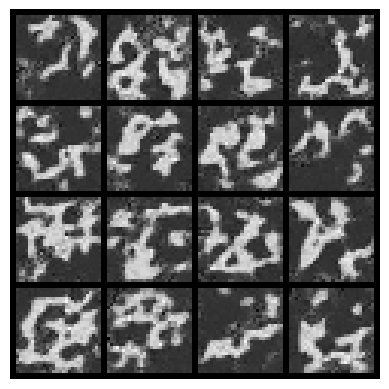

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
dataloader = get_data()

train(model, dataloader, optimizer)

samples = sample(model, 28, 16)
grid = torchvision.utils.make_grid(samples.cpu(), nrow=4, normalize=True)
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()
